# Анализ клиентской базы сети фитнес-центров и прогнозирование вероятности оттока

В данном проекте на основе данных клиентской базы сети фитнес-центров проведем разбивку клиентов по группам по определенным признакам. Помимо этого, спрогнозируем вероятность оттока клиентов из сети фитнес-центров, выделим параметры, которые оказывают наиболее сильное влияние на отток клиентов. В конце будут даны рекомендации по работе с имеющимися клиентами, меры по снижению оттока, выделим другие особенности взаимодействия с клиентами.

# План работы

- [Исследовательский анализ данных и предобработка данных](#подготовка)
- [Прогнозирование оттока клиентов на основе LogisticRegression и RandomForestClassifier](#модель)
- [Кластеризация киентской базы](#кластеризация)
- [Выводы и рекомендации](#заключение)

# Исследовательский анализ данных <a id="подготовка"></a>

In [1]:
# Импортируем нужные для работы библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.cluster import KMeans
import itertools
from itertools import combinations
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
df = pd.read_csv ('/datasets/gym_churn.csv')
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Предварительная оценка данных показала, что в датасете нет пропусков, все значения числовые, что облегчит задачу по построению модели прогнозирования оттока

In [4]:
df[df.duplicated()]

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn


Также в датасете отсутствуют дубликаты

In [5]:
df.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


По описанию датасета можно сделать следующие выводы: данные, которые представлены в **бинарной системе**, по среднему значениею либо выглядят примерно равновесно, например как в столбце **gender**, либо имеют явный перекос в какую либо сторону, например как в столбцах. В **gender** данные распределены примерно пополам, одинаково имеются представители мужского и женского полов. Клиенты в основном живут или работают в одном районе с фитнес-центром. Примерно пополам делятся клиенты, которые пришли по парнерским программам с фитнес-центром и которые пришли самостоятельно, не имеют права на скидку, так как не парнеры фитнес-центра. **Промокодами** воспользовалась примерно треть пришедших клиентов. В основном клиенты оставляют свои **контактные данные** - таковых клиентов 90%. С небольшим перевесом, люди предпочитают **индивидуальные тренировки**. В основном клиенты предпочитают приобретать **абонементы на 1 месяц**. В среднем возраст клиентов около **29 лет**. Отток клиентов из сети фитнес-центров достигает **26%**. 
<p>Про стандартное отклонение тут говорить особого смысла нет, так как в бинарной системе всего два значения и показатель стандартного отклонения будет и так низким, показывая, что данные примерно близки к среднему значению. Да и даже в столбцах с небинарными показателями, стандартное отклонение показывает, что значения близки к ожидаемым.</p>

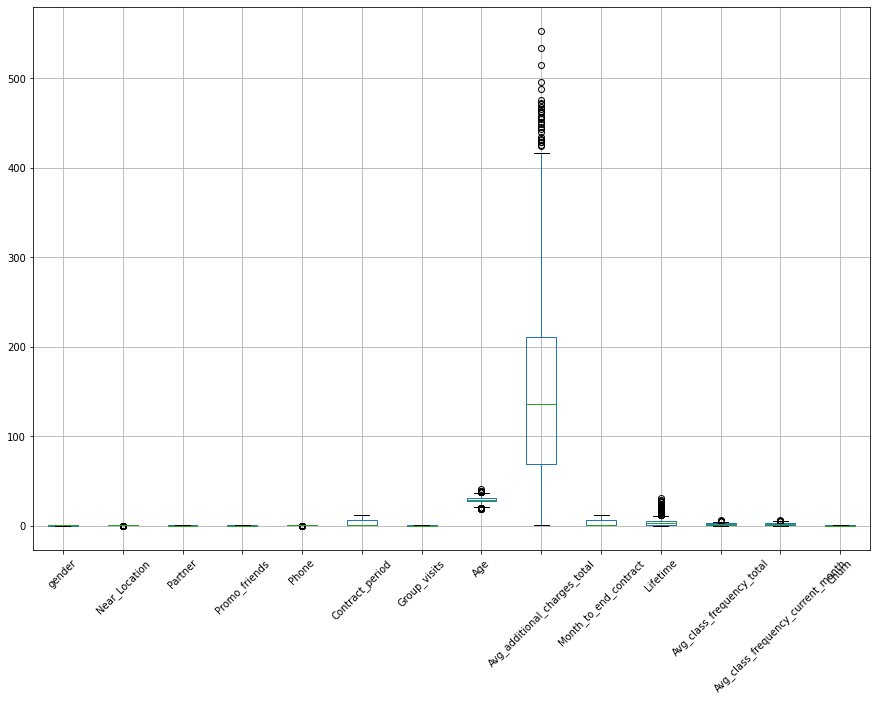

In [6]:
df.boxplot(figsize=(15,10), rot=45)
plt.show()

In [7]:
df.query('Churn == 0').describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.000000,2939.0
mean,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882,0.0
std,0.499984,0.332933,0.498914,0.478144,0.295040,4.716942,0.498795,3.009933,99.801599,4.363522,3.874780,1.016006,1.018994,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,19.000000,0.171862,1.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,28.000000,76.920993,1.000000,2.000000,1.283137,1.297021,0.0
50%,1.000000,1.000000,1.000000,0.000000,1.000000,6.000000,0.000000,30.000000,149.881171,6.000000,4.000000,2.043252,2.046697,0.0
75%,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,32.000000,224.448274,10.000000,6.000000,2.732944,2.740648,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,0.0


In [8]:
df.query('Churn == 1').describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.0
mean,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546,1.0
std,0.500118,0.422217,0.478837,0.387495,0.296204,2.132371,0.443448,2.895163,77.696419,1.964593,1.110799,0.694705,0.770237,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,25.000000,50.629127,1.000000,0.000000,1.010771,0.421337,1.0
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,103.814686,1.000000,1.000000,1.491187,0.979445,1.0
75%,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,29.000000,165.616858,1.000000,1.000000,1.956438,1.588576,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,38.000000,425.535220,12.000000,9.000000,3.478646,3.540271,1.0


Если сравнивать клиентские данные в зависимости от того, действующий ли это клиент или ушедший в отток, то можно сделать следующие выводы: 
- по **гендерному признаку нет особых различий**, доли что в действующих, что в оттоке примерно одинаковые; 
- среди действующих клиентов **доля тех, кто проживает или работает в одном районе** с фитнес-центром **выше**, чем среди клиентов из оттока;
- доля клиентов пришедших в фитнес-центр **по парнерским программам** также выше среди действующих клиентов;
- действующие клиенты также **чаще приходят в фитнес-центр по промокодам** от друзей/коллег, чем среди тех кто ушел в отток;
- по **наличию контактных данных** разницы нет;
- среди **действующих клиентов**, которые приобретают себе абонементы, **среднее значение приближается к 6**, а значит налицо то, что абонементы **приобретаются не только на 1 месяц, но и на полгода, год**, причем в достаточно больших количествах. А с теми, клиентами кто **ушел в отток**, ситуация обратная, там **по среднему значению** можно сделать вывод, что **в основном абонементы приобретаются на месяц** и лишь небольшая доля клиентов приобрела их на полгода, год;
- интересное предположение можно сделать по столбцу **group_visits**. Среди действующих клиентов среднее значение гораздо выше, чем среди тех клиентов, кто ушел в отток. Можно предположить, что действующие клиенты предпочитают ходит на тренировки вместе, возможно и к одному тренеру;
- **средний возраст** действующих клиентов близится к 30, ушедших в отток - к 27;
- вполне очевидно, что действующие клиенты чаще тратятся на дополнительные услуги, поэтому и среднее выше, чес у тех, кто ушел в отток;
- по **lifetime** также ничего удивительного. Действующие клиенты держатся намного дольше, среднее приближается к 5 месяцам, среди клиентов в оттоке среднее доходит примерно до 1 месяца;
- по **количеству тренировок** видим, что **действующие клиенты** стараются посещать зал примерно **2 раза в неделю**, **ушедшие в отток - раз в неделю**.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


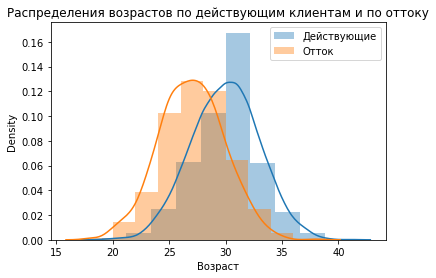

In [9]:
sns.distplot(df.query('Churn == 0')['Age'], bins=10, label='Действующие')
sns.distplot(df.query('Churn == 1')['Age'], bins=10, label='Отток')
plt.title('Распределения возрастов по действующим клиентам и по оттоку')
plt.xlabel('Возраст')
plt.legend()
plt.show()

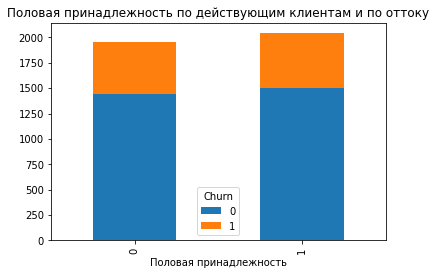

In [10]:
gender = df.pivot_table(index='gender', columns='Churn', values='Partner', aggfunc='count')
gender.plot(kind='bar', stacked=True)
plt.title('Половая принадлежность по действующим клиентам и по оттоку')
plt.xlabel('Половая принадлежность')
plt.show()

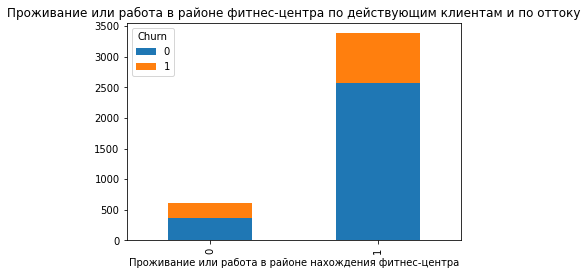

In [11]:
near_location = df.pivot_table(index='Near_Location', columns='Churn', values='Partner', aggfunc='count')
near_location.plot(kind='bar', stacked=True)
plt.title('Проживание или работа в районе фитнес-центра по действующим клиентам и по оттоку')
plt.xlabel('Проживание или работа в районе нахождения фитнес-центра')
plt.show()

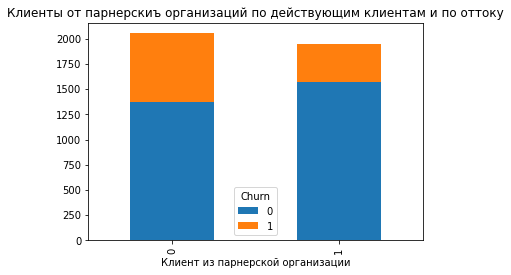

In [12]:
partner = df.pivot_table(index='Partner', columns='Churn', values='gender', aggfunc='count')
partner.plot(kind='bar', stacked=True)
plt.title('Клиенты от парнерскиъ организаций по действующим клиентам и по оттоку')
plt.xlabel('Клиент из парнерской организации')
plt.show()

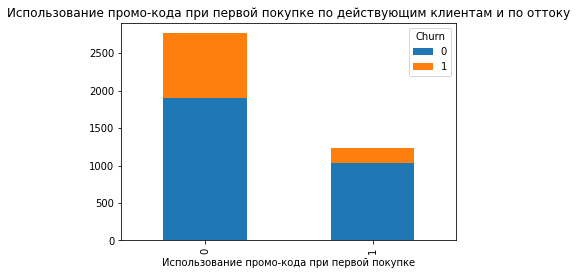

In [13]:
promo_friends = df.pivot_table(index='Promo_friends', columns='Churn', values='Partner', aggfunc='count')
promo_friends.plot(kind='bar', stacked=True)
plt.title('Использование промо-кода при первой покупке по действующим клиентам и по оттоку')
plt.xlabel('Использование промо-кода при первой покупке')
plt.show()

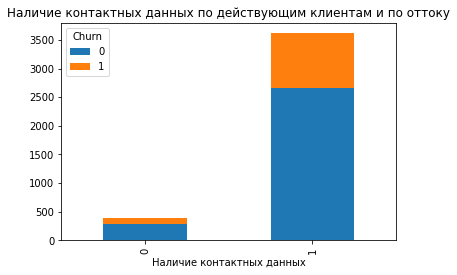

In [14]:
phone = df.pivot_table(index='Phone', columns='Churn', values='Partner', aggfunc='count')
phone.plot(kind='bar', stacked=True)
plt.title('Наличие контактных данных по действующим клиентам и по оттоку')
plt.xlabel('Наличие контактных данных')
plt.show()

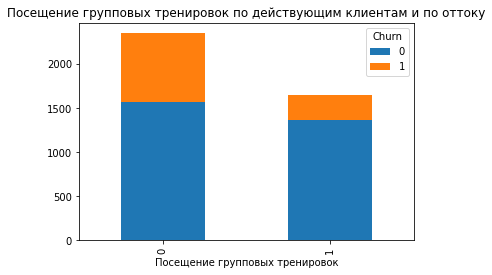

In [15]:
group_visits = df.pivot_table(index='Group_visits', columns='Churn', values='Partner', aggfunc='count')
group_visits.plot(kind='bar', stacked=True)
plt.title('Посещение групповых тренировок по действующим клиентам и по оттоку')
plt.xlabel('Посещение групповых тренировок')
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


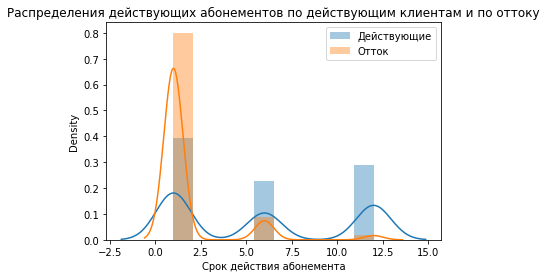

In [16]:
sns.distplot(df.query('Churn == 0')['Contract_period'], bins=10, label='Действующие')
sns.distplot(df.query('Churn == 1')['Contract_period'], bins=10, label='Отток')
plt.title('Распределения действующих абонементов по действующим клиентам и по оттоку')
plt.xlabel('Срок действия абонемента')
plt.legend()
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


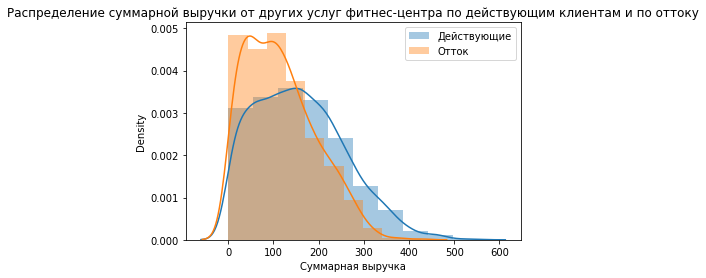

In [17]:
sns.distplot(df.query('Churn == 0')['Avg_additional_charges_total'], bins=10, label='Действующие')
sns.distplot(df.query('Churn == 1')['Avg_additional_charges_total'], bins=10, label='Отток')
plt.title('Распределение суммарной выручки от других услуг фитнес-центра по действующим клиентам и по оттоку')
plt.xlabel('Суммарная выручка')
plt.legend()
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


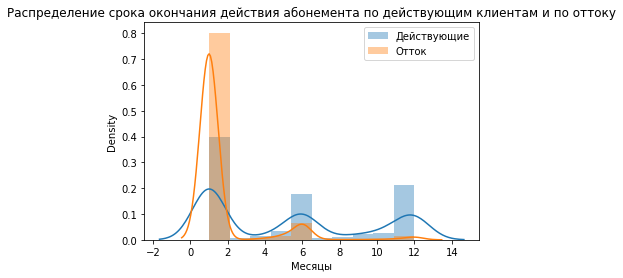

In [18]:
sns.distplot(df.query('Churn == 0')['Month_to_end_contract'], bins=10, label='Действующие')
sns.distplot(df.query('Churn == 1')['Month_to_end_contract'], bins=10, label='Отток')
plt.title('Распределение срока окончания действия абонемента по действующим клиентам и по оттоку')
plt.xlabel('Месяцы')
plt.legend()
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


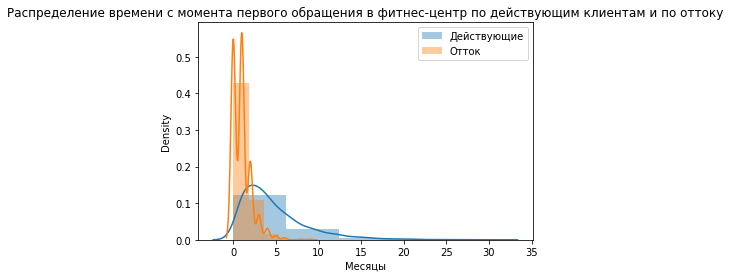

In [19]:
sns.distplot(df.query('Churn == 0')['Lifetime'], bins=5, label='Действующие')
sns.distplot(df.query('Churn == 1')['Lifetime'], bins=5, label='Отток')
plt.title('Распределение времени с момента первого обращения в фитнес-центр по действующим клиентам и по оттоку')
plt.xlabel('Месяцы')
plt.legend()
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


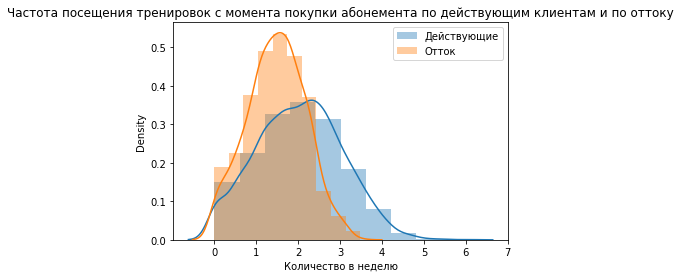

In [20]:
sns.distplot(df.query('Churn == 0')['Avg_class_frequency_total'], bins=10, label='Действующие')
sns.distplot(df.query('Churn == 1')['Avg_class_frequency_total'], bins=10, label='Отток')
plt.title('Частота посещения тренировок с момента покупки абонемента по действующим клиентам и по оттоку')
plt.xlabel('Количество в неделю')
plt.legend()
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


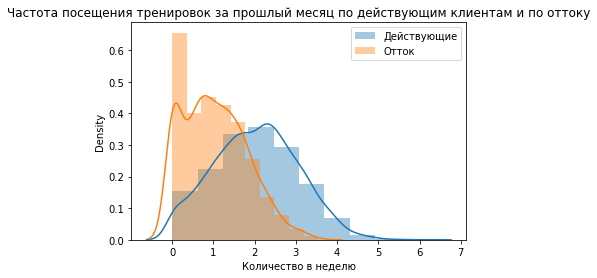

In [21]:
sns.distplot(df.query('Churn == 0')['Avg_class_frequency_current_month'], bins=10, label='Действующие')
sns.distplot(df.query('Churn == 1')['Avg_class_frequency_current_month'], bins=10, label='Отток')
plt.title('Частота посещения тренировок за прошлый месяц по действующим клиентам и по оттоку')
plt.xlabel('Количество в неделю')
plt.legend()
plt.show()

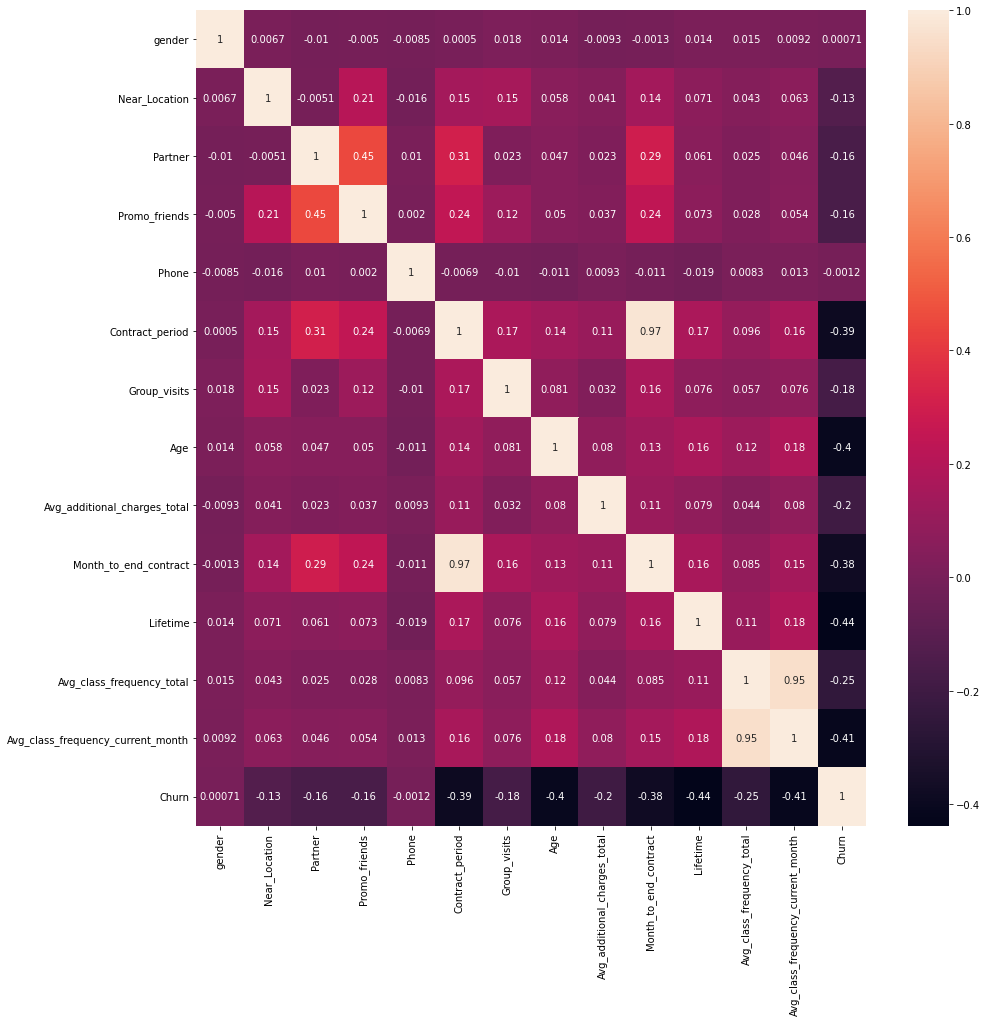

In [22]:
cm = df.corr()


plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True)

plt.show()

На матрице корреляций есть данные которые сильно между собой коррелируют: **Частота посещений с момента покупки абонемента** и **Частота посещений за последний месяц**, а также **Срок действия абонемента** и **срок до конца действия абомнемента**. На мой взгляд, стоит исключить из матрицы корреляций **Частота посещений за последний месяц** и **срок до конца действия абомнемента**. Данная логика объясняется тем, что это очень близкие по значению данные, которые перетягиваются на себя все внимание. Частота тренировок обычно не меняется, если клиент заложил себе норму на неделю. А поскольку в основном приобретаются месячные абонементы, то **срок до конца его действия** будет совпадать со **сроком действия абонемента** Корреляция между ними не несет особой смысловой нагрузки и сложно оценить другие взаимосвязи.

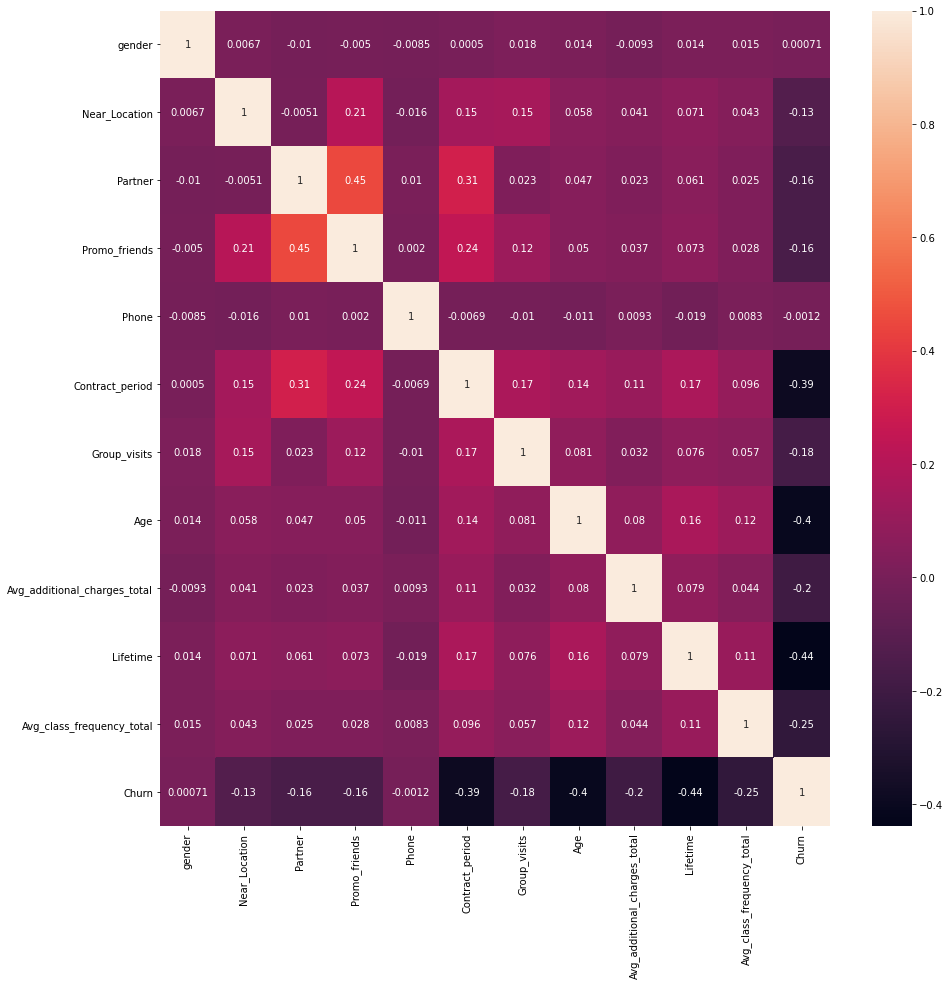

In [23]:
df_corr = df.drop(['Avg_class_frequency_current_month', 'Month_to_end_contract'], axis=1)
cm = df_corr.corr()


plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True)

plt.show()

По новой матрице видим, что есть некоторая взаимосвязь между **местом проживания или работы** и **использованием промокода**, **партнерской организацией** и **использованием промокода**, **партнерской организацией** и **сроком действия абонемента**, **сроком действия абонемента** и **использованием промокода**.
Данные взаимосвязи могут объясняться так:
- Сотрудники одной парнерской организации делятся друг с другом промокодами;
- Сотрудники партнерской организации, имея скидку, могут приобрести абонемент на более долги срок;
- Имея скидку по промокоду на первую покупку, клиенты также могут приобрести абенемент на долги срок;
- Проживающие в одном районе вместе с фитнес-центром друзья, или работающие коллеги из непартнерских организаций могут также делиться друг с другом промокодами на покупку.
- Ни один признак сам по себе сильно не влияет на отток, значит они работают в совокупности, либо необходимы еще данные о клиентах

# Модель прогнозирования оттока клиентов на основе LogisticRegression  и RandomForestClassifier <a id="модель"></a>

In [24]:
# задаем переменные без целевого значения и с целевым значением
X = df.drop('Churn', axis = 1)
y = df['Churn']
# делим выборку в соотношении 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# задаем алгоритм
model = LogisticRegression(solver='liblinear')
# обучаем модель
model.fit(X_train, y_train)
# делаем прогнозы на основе обученной модели
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:,1]

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions)))
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, probabilities)))

Accuracy: 0.93
Precision: 0.86
Recall: 0.83
F1: 0.85
ROC_AUC: 0.97


In [25]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
# обучим модель случайного леса
rf_model.fit(X_train, y_train)
# сделаем прогнозы на основе обученной модели
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:,1]
# выведем все метрики
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, rf_predictions)))
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, rf_probabilities)))

Accuracy: 0.92
Precision: 0.84
Recall: 0.82
F1: 0.83
ROC_AUC: 0.97


В целом модели показали себя +- одинкаково, разве что показатели Логистической регрессии показали себя чуть лучше Случайнго леса.

# Кластеризация клиентов финтес-центра <a id="кластеризация"></a>

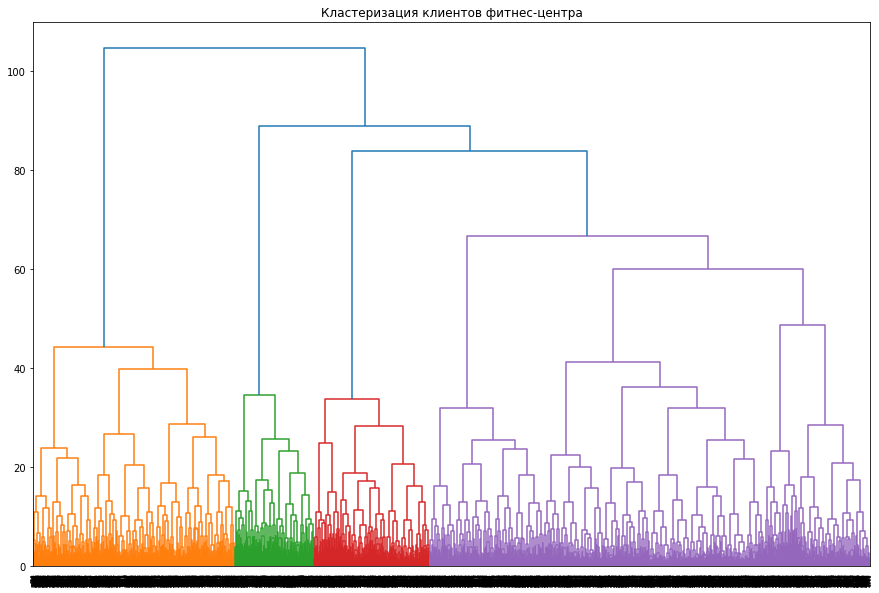

In [26]:
# стандартизируем данные без целевого показателя (Churn)
df_no_churn = df.drop('Churn', axis=1)
sc = StandardScaler()
x_sc = sc.fit_transform(df_no_churn)
# в переменной linked сохранена таблица «связок» между объектами
linked = linkage(x_sc, method = 'ward')
# отрисуем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация клиентов фитнес-центра')
plt.show()

In [27]:
km = KMeans(n_clusters=5, random_state=0) # задаём число кластеров, равное 5, и фиксируем значение random_state для воспроизводимости результата
labels = km.fit_predict(x_sc) # применяем алгоритм к данным и формируем вектор кластеров
# сохраняем метки кластера в поле нашего датасета
df_no_churn['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
print(df_no_churn.groupby('cluster_km').mean())

              gender  Near_Location   Partner  Promo_friends     Phone  \
cluster_km                                                               
0           0.502970       0.959406  0.783168       0.574257  1.000000   
1           0.522078       0.862338  0.470130       0.306494  0.000000   
2           0.495050       0.000000  0.463366       0.079208  1.000000   
3           0.485737       1.000000  0.350238       0.240095  1.000000   
4           0.559666       0.976134  0.356802       0.230310  0.998807   

            Contract_period  Group_visits        Age  \
cluster_km                                             
0                 10.889109      0.542574  29.982178   
1                  4.787013      0.425974  29.301299   
2                  2.352475      0.215842  28.477228   
3                  1.948494      0.341521  28.167987   
4                  2.669451      0.473747  30.125298   

            Avg_additional_charges_total  Month_to_end_contract  Lifetime  \
cluster_km 

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

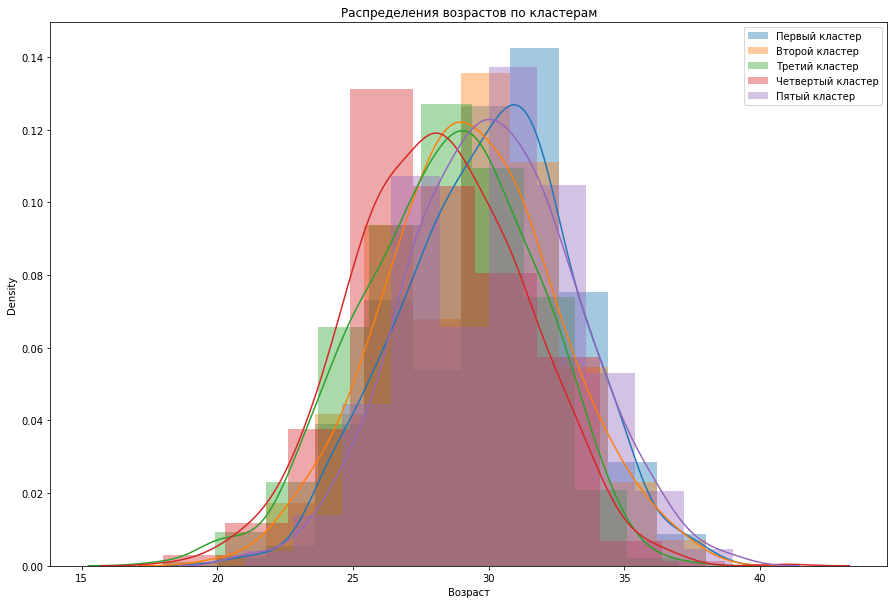

In [28]:
plt.figure(figsize=(15,10))
sns.distplot(df_no_churn.query('cluster_km == 0')['Age'], bins=10, label='Первый кластер')
sns.distplot(df_no_churn.query('cluster_km == 1')['Age'], bins=10, label='Второй кластер')
sns.distplot(df_no_churn.query('cluster_km == 2')['Age'], bins=10, label='Третий кластер')
sns.distplot(df_no_churn.query('cluster_km == 3')['Age'], bins=10, label='Четвертый кластер')
sns.distplot(df_no_churn.query('cluster_km == 4')['Age'], bins=10, label='Пятый кластер')
plt.title('Распределения возрастов по кластерам')
plt.xlabel('Возраст')
plt.legend()
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

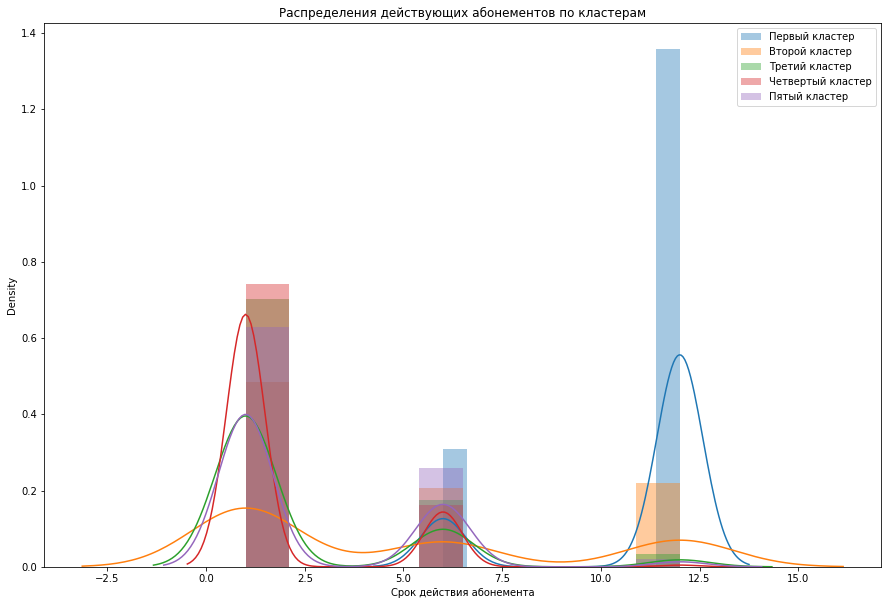

In [29]:
plt.figure(figsize=(15,10))
sns.distplot(df_no_churn.query('cluster_km == 0')['Contract_period'], bins=10, label='Первый кластер')
sns.distplot(df_no_churn.query('cluster_km == 1')['Contract_period'], bins=10, label='Второй кластер')
sns.distplot(df_no_churn.query('cluster_km == 2')['Contract_period'], bins=10, label='Третий кластер')
sns.distplot(df_no_churn.query('cluster_km == 3')['Contract_period'], bins=10, label='Четвертый кластер')
sns.distplot(df_no_churn.query('cluster_km == 4')['Contract_period'], bins=10, label='Пятый кластер')
plt.title('Распределения действующих абонементов по кластерам')
plt.xlabel('Срок действия абонемента')
plt.legend()
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

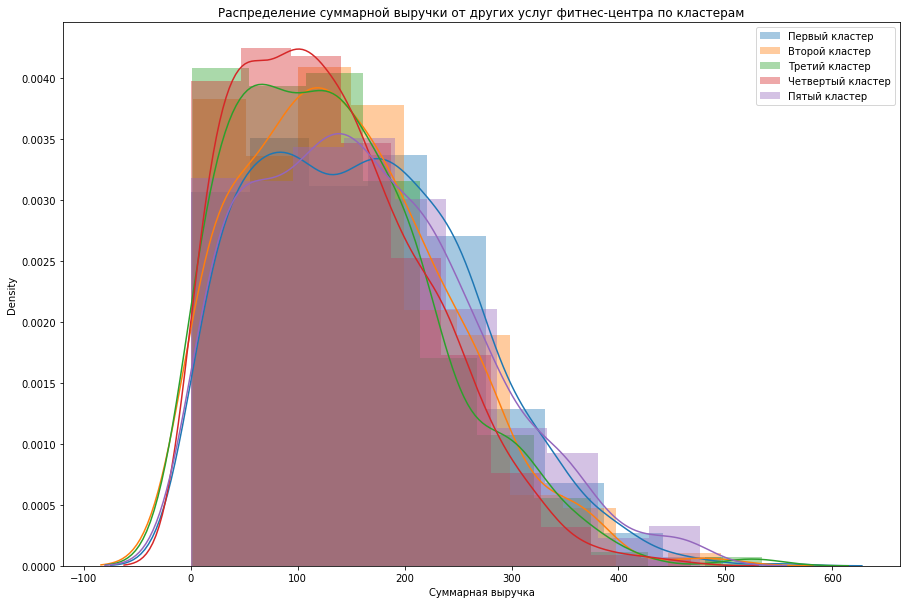

In [30]:
plt.figure(figsize=(15,10))
sns.distplot(df_no_churn.query('cluster_km == 0')['Avg_additional_charges_total'], bins=10, label='Первый кластер')
sns.distplot(df_no_churn.query('cluster_km == 1')['Avg_additional_charges_total'], bins=10, label='Второй кластер')
sns.distplot(df_no_churn.query('cluster_km == 2')['Avg_additional_charges_total'], bins=10, label='Третий кластер')
sns.distplot(df_no_churn.query('cluster_km == 3')['Avg_additional_charges_total'], bins=10, label='Четвертый кластер')
sns.distplot(df_no_churn.query('cluster_km == 4')['Avg_additional_charges_total'], bins=10, label='Пятый кластер')
plt.title('Распределение суммарной выручки от других услуг фитнес-центра по кластерам')
plt.xlabel('Суммарная выручка')
plt.legend()
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

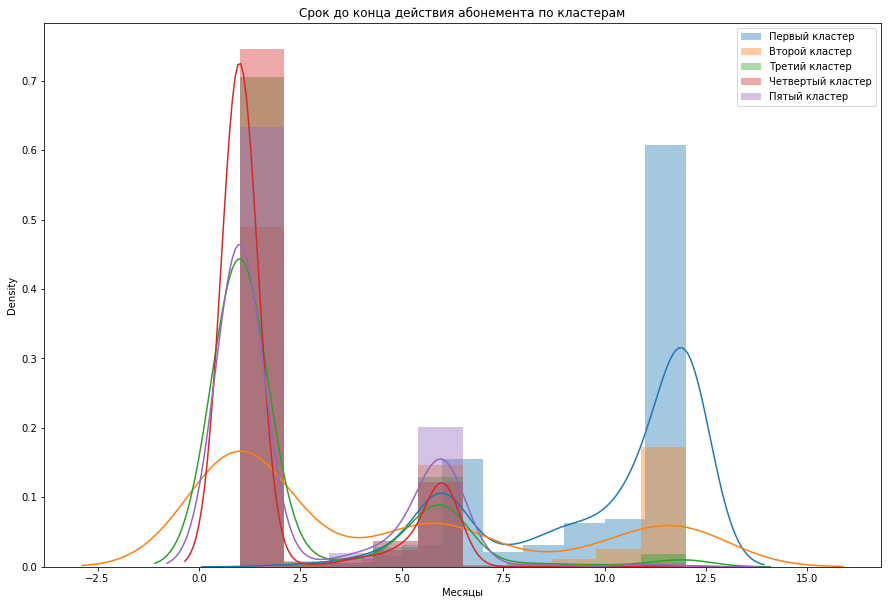

In [31]:
plt.figure(figsize=(15,10))
sns.distplot(df_no_churn.query('cluster_km == 0')['Month_to_end_contract'], bins=10, label='Первый кластер')
sns.distplot(df_no_churn.query('cluster_km == 1')['Month_to_end_contract'], bins=10, label='Второй кластер')
sns.distplot(df_no_churn.query('cluster_km == 2')['Month_to_end_contract'], bins=10, label='Третий кластер')
sns.distplot(df_no_churn.query('cluster_km == 3')['Month_to_end_contract'], bins=10, label='Четвертый кластер')
sns.distplot(df_no_churn.query('cluster_km == 4')['Month_to_end_contract'], bins=10, label='Пятый кластер')
plt.title('Срок до конца действия абонемента по кластерам')
plt.xlabel('Месяцы')
plt.legend()
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

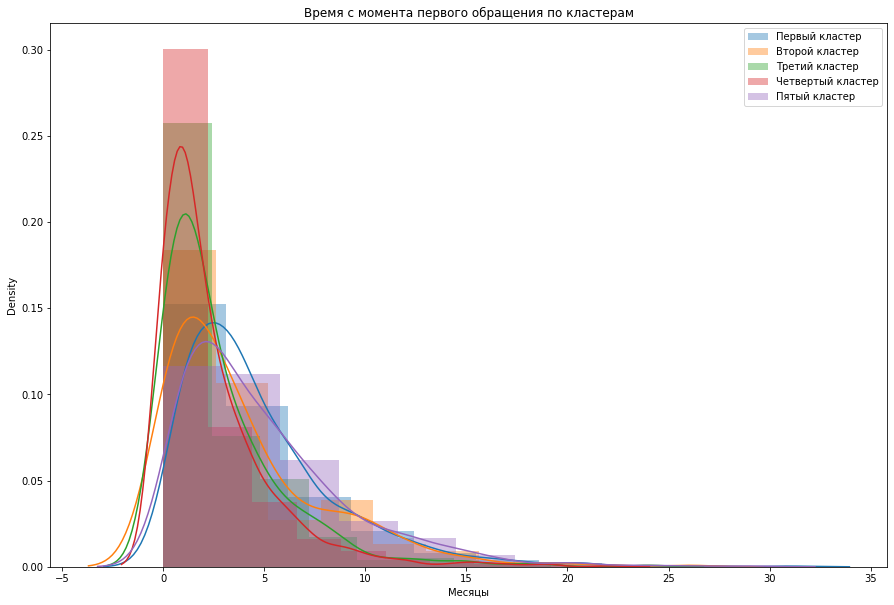

In [32]:
plt.figure(figsize=(15,10))
sns.distplot(df_no_churn.query('cluster_km == 0')['Lifetime'], bins=10, label='Первый кластер')
sns.distplot(df_no_churn.query('cluster_km == 1')['Lifetime'], bins=10, label='Второй кластер')
sns.distplot(df_no_churn.query('cluster_km == 2')['Lifetime'], bins=10, label='Третий кластер')
sns.distplot(df_no_churn.query('cluster_km == 3')['Lifetime'], bins=10, label='Четвертый кластер')
sns.distplot(df_no_churn.query('cluster_km == 4')['Lifetime'], bins=10, label='Пятый кластер')
plt.title('Время с момента первого обращения по кластерам')
plt.xlabel('Месяцы')
plt.legend()
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

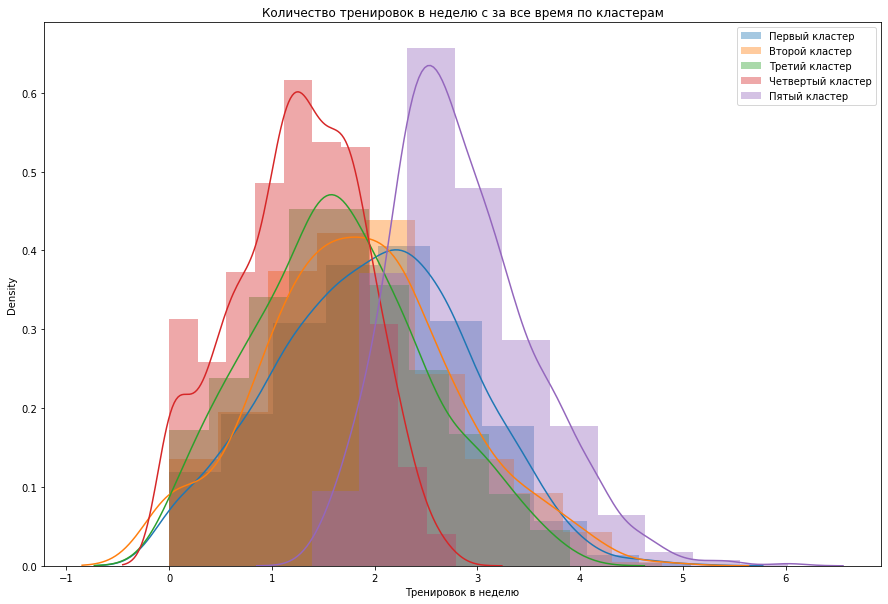

In [33]:
plt.figure(figsize=(15,10))
sns.distplot(df_no_churn.query('cluster_km == 0')['Avg_class_frequency_total'], bins=10, label='Первый кластер')
sns.distplot(df_no_churn.query('cluster_km == 1')['Avg_class_frequency_total'], bins=10, label='Второй кластер')
sns.distplot(df_no_churn.query('cluster_km == 2')['Avg_class_frequency_total'], bins=10, label='Третий кластер')
sns.distplot(df_no_churn.query('cluster_km == 3')['Avg_class_frequency_total'], bins=10, label='Четвертый кластер')
sns.distplot(df_no_churn.query('cluster_km == 4')['Avg_class_frequency_total'], bins=10, label='Пятый кластер')
plt.title('Количество тренировок в неделю с за все время по кластерам')
plt.xlabel('Тренировок в неделю')
plt.legend()
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

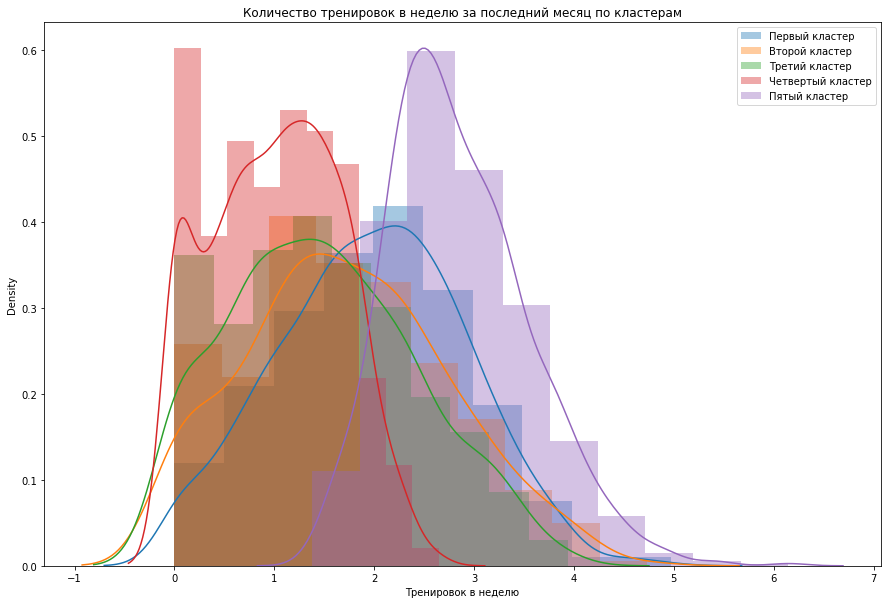

In [34]:
plt.figure(figsize=(15,10))
sns.distplot(df_no_churn.query('cluster_km == 0')['Avg_class_frequency_current_month'], bins=10, label='Первый кластер')
sns.distplot(df_no_churn.query('cluster_km == 1')['Avg_class_frequency_current_month'], bins=10, label='Второй кластер')
sns.distplot(df_no_churn.query('cluster_km == 2')['Avg_class_frequency_current_month'], bins=10, label='Третий кластер')
sns.distplot(df_no_churn.query('cluster_km == 3')['Avg_class_frequency_current_month'], bins=10, label='Четвертый кластер')
sns.distplot(df_no_churn.query('cluster_km == 4')['Avg_class_frequency_current_month'], bins=10, label='Пятый кластер')
plt.title('Количество тренировок в неделю за последний месяц по кластерам')
plt.xlabel('Тренировок в неделю')
plt.legend()
plt.show()

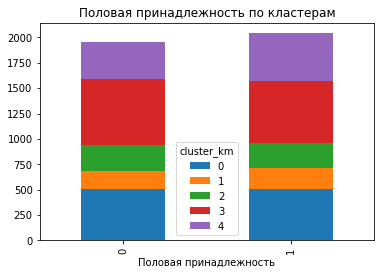

In [35]:
gender_no_churn = df_no_churn.pivot_table(index='gender', columns='cluster_km', values='Partner', aggfunc='count')
gender_no_churn.plot(kind='bar', stacked=True)
plt.title('Половая принадлежность по кластерам')
plt.xlabel('Половая принадлежность')
plt.show()

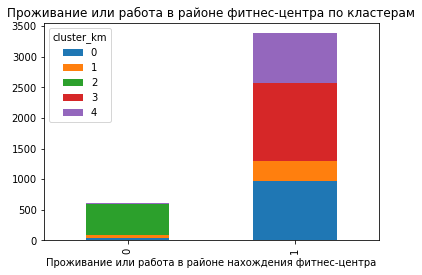

In [36]:
near_location_no_churn = df_no_churn.pivot_table(index='Near_Location', columns='cluster_km', values='Partner', aggfunc='count')
near_location_no_churn.plot(kind='bar', stacked=True)
plt.title('Проживание или работа в районе фитнес-центра по кластерам')
plt.xlabel('Проживание или работа в районе нахождения фитнес-центра')
plt.show()

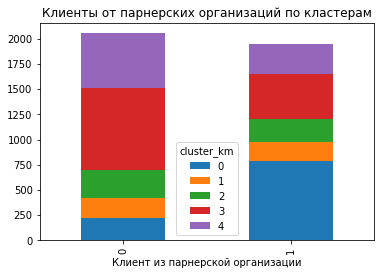

In [37]:
partner_no_churn = df_no_churn.pivot_table(index='Partner', columns='cluster_km', values='gender', aggfunc='count')
partner_no_churn.plot(kind='bar', stacked=True)
plt.title('Клиенты от парнерских организаций по кластерам')
plt.xlabel('Клиент из парнерской организации')
plt.show()

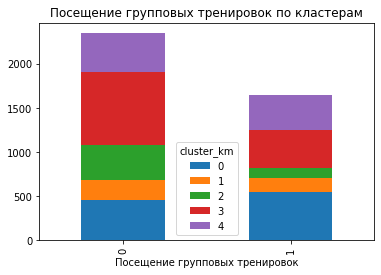

In [38]:
group_visits_no_churn = df_no_churn.pivot_table(index='Group_visits', columns='cluster_km', values='Partner', aggfunc='count')
group_visits_no_churn.plot(kind='bar', stacked=True)
plt.title('Посещение групповых тренировок по кластерам')
plt.xlabel('Посещение групповых тренировок')
plt.show()

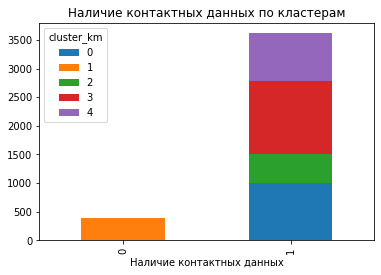

In [39]:
phone_no_churn = df_no_churn.pivot_table(index='Phone', columns='cluster_km', values='Partner', aggfunc='count')
phone_no_churn.plot(kind='bar', stacked=True)
plt.title('Наличие контактных данных по кластерам')
plt.xlabel('Наличие контактных данных')
plt.show()

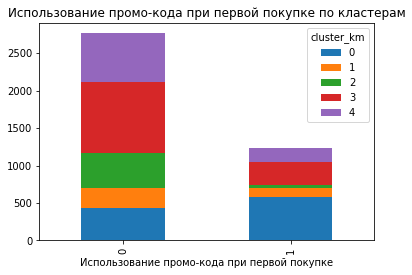

In [40]:
promo_friends_no_churn = df_no_churn.pivot_table(index='Promo_friends', columns='cluster_km', values='Partner', aggfunc='count')
promo_friends_no_churn.plot(kind='bar', stacked=True)
plt.title('Использование промо-кода при первой покупке по кластерам')
plt.xlabel('Использование промо-кода при первой покупке')
plt.show()

In [41]:
df['cluster_km'] = labels
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn,cluster_km
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0,1
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0,3
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0,3


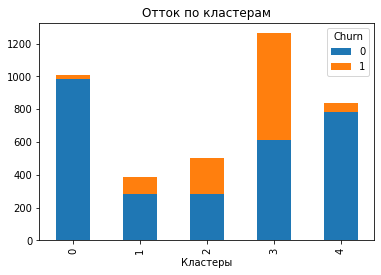

In [42]:
cluster_churn = df.pivot_table(index='cluster_km', columns='Churn', values='gender', aggfunc='count')
cluster_churn.plot(kind='bar', stacked=True)
plt.title('Отток по кластерам')
plt.xlabel('Кластеры')
plt.show()

По надежности групп клиетов, можно сказать, что самыми надежными клиентами являются клиенты 1 и 5 групп, а  4 группа - склонная к оттоку, 2 и 3 группу можно записать в ненадежные. Несколько удивителен факт, что 4 группа клиентов вся проживает или работает в одном районе с фитнес-центром, но она же при этом склонна к оттоку. Это самая молодая группа, средний возраст чуть за 28, берут в основном месячные абонементы. Вероятнее всего, это группа состоит из клиентов, которые на волне импульса решили изменить свою жизнь к лучшему, но что-то пошло не так и они ушли в отток.
<p>Первая группа это в основном клиенты из партнерских организаций, половина которых еще к тому же пришли по промокодам. Также эта группа клиентов приобретает абонементы на долгий срок, склонны ходить на групповые тренировки с коллегами. Эта группа клиентов также настроена тратиться на прочие услуги центра.</p>
<p>Вторая группа клиентов совсем не оставила контактных данных. Это нехороший признак, так как, вероятно, такие клиенты могут потом пропасть, а фитнес-центр не сможет им о себе напомнить или они могут пропустить специальные предложения от сети фитнес-центров.</p>
<p>Пятая группа клиентов довольно часто тренируется, средний показатель частоты посещения близится к 3 тренировкам в неделю. Вероятно, это не просто клиенты, следящие за своим здоровье, а спортсмены, культуристы, для кого спорт это уже скорее потребность, нежели просто способ поддержание формы. Эта же группа надежных клиентов. Они неплохо тратяться на другие услуги центра, наверно спортивное питание. В этой группе клиентов также имеется больший перекос в сторону одного из полов, вероятно мужского пола (надеюсь никого не обижу).</p>
<p>Третья группа клиентов не проживает или не работает в одном районе с фитнес-центром. Этот факт можно интерпретировать так, что в конечном итоге клиент может уйти в отток из-за невозможности проводить много времени в дороге до фитнес-центра.</p>

# Выводы и рекомендации <a id="заключение"></a>

По проекту можно сделать следующие выводы:

- среди действующих клиентов доля тех, кто проживает или работает в одном районе с фитнес-центром выше, чем среди клиентов из оттока. Подавляющее число клиентов из надеждных групп клиентов живет или работает рядом с фитнес-центрами, а вот третью группу можно записать в ненадежные, так как они не из одного района с фитнес-центром;
- доля клиентов пришедших в фитнес-центр по парнерским программам также выше среди действующих клиентов. Клиенты от парнерских организаций составляют первую группу;
- действующие клиенты также чаще приходят в фитнес-центр по промокодам от друзей/коллег, чем среди тех кто ушел в отток. Также составляют первую группу;
- среди действующих клиентов, которые приобретают себе абонементы, среднее значение приближается к 6, а значит налицо то, что абонементы приобретаются не только на 1 месяц, но и на полгода, год, причем в достаточно больших количествах. А с теми, клиентами кто ушел в отток, ситуация обратная, там по среднему значению можно сделать вывод, что в основном абонементы приобретаются на месяц и лишь небольшая доля клиентов приобрела их на полгода, год. Сразу на долгий срок приобретают себе абонементы клиенты первой группы, кто идет от парнерских организаций и достаточно часто по промокодам;
- средний возраст действующих клиентов близится к 30, ушедших в отток - к 27; Четвертая группа, к примеру, самая молодая, вероятно склонна к импульсам и стремлениям изменить свою жизнь к лучшему, но их надолго не хватает, они уходят в отток. А вот 1 и 5 группа клиентов, наоборот старше, и, вероятно, более осознанно подходят к тренировочному процессу;
- вполне очевидно, что действующие клиенты чаще тратятся на дополнительные услуги, поэтому и среднее выше, чес у тех, кто ушел в отток. Первая и пятая группы надежных клиентов тратятся больше, чем остальные группы;
- по количеству тренировок видим, что действующие клиенты стараются посещать зал примерно 2 раза в неделю, ушедшие в отток - раз в неделю. Первая и пятая группы ходят чаще всего - 2 и более тренировки.

Рекомендации:
- Желательно собираться с клиентов контактные данные. Есть клиенты, которые их не оставляют, они потом могут не получать специальные предложения на абонементы. Также контактные данные могут помочь клиентам напоминать о действующих абонементах, если клиент не появляется в фитнес-центре в течение 1-2 недель. Можно получать контактные данные, например привязывая абонемент к номеру телефона, чтобы в случае, если забыл карточку, можно было пройти назвав номер телефона;
- Стимулировать имеющихся клиентов приглашать своих друзей и коллег по промокодам. По имеющимся выводам, толькопервая группа клиентов может похвастаться большой долей привлеченных клиентов по промокодам. Можно объявить акцию а-ля приведи друга, получишь скидку на оплату следующего абонемента;
- Развивать парнерские, или корпоративные, программы, поскольку они дают более стабильных и надежных клиентов. Например, за сотрудниками одной парнерской организации можно закрепить персонального менеджера, тренера, которые, прежде всего, не дадут забить на фитнес-центр, будут мотивировать клиентов ходить заниматься. Для сотрудников компаний-партнеров можно сделать небольшие скидки на другие услуги фитнес-центра (кофе, спа, спортивное питание). Сюда же можно добавить еще проведение тренингов, лекций о правильном и функциональном питании, проведение для сотрудников компании-партнера открытых занятий с целью привлечения новых клиентов от организации. Вариантов достаточно много:)


In [43]:
columns = list(df_no_churn)
columns

['gender',
 'Near_Location',
 'Partner',
 'Promo_friends',
 'Phone',
 'Contract_period',
 'Group_visits',
 'Age',
 'Avg_additional_charges_total',
 'Month_to_end_contract',
 'Lifetime',
 'Avg_class_frequency_total',
 'Avg_class_frequency_current_month',
 'cluster_km']

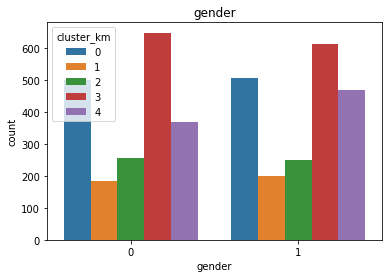

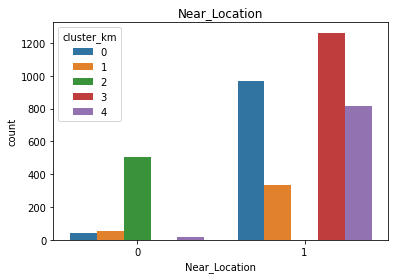

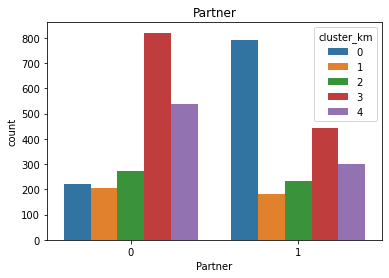

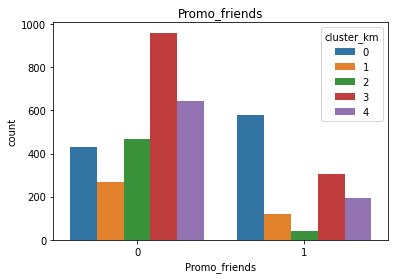

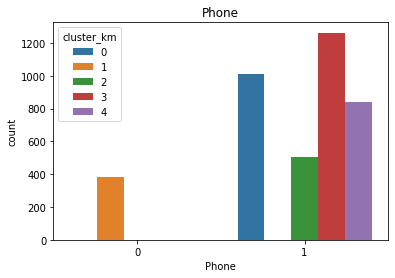

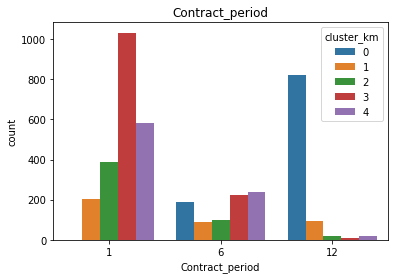

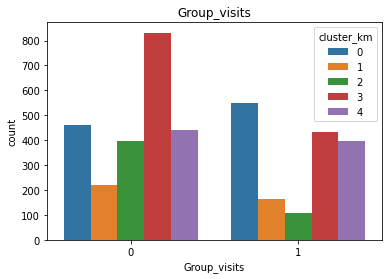

In [44]:
for column in ['gender',
 'Near_Location',
 'Partner',
 'Promo_friends',
 'Phone',
 'Contract_period',
 'Group_visits']:
    sns.countplot(x = df_no_churn[column], hue='cluster_km', data=df_no_churn)
    plt.title(column)
    plt.show()

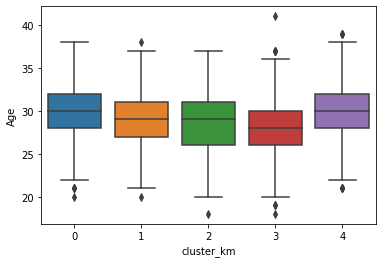

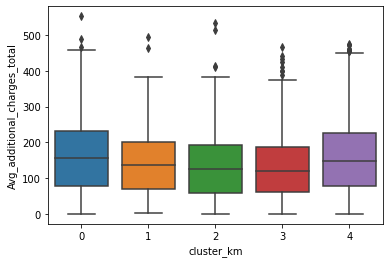

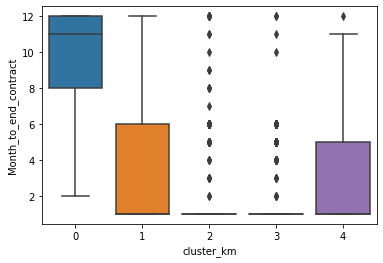

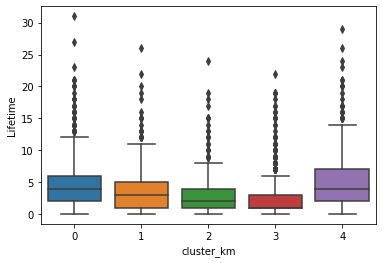

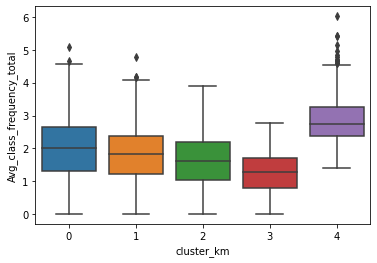

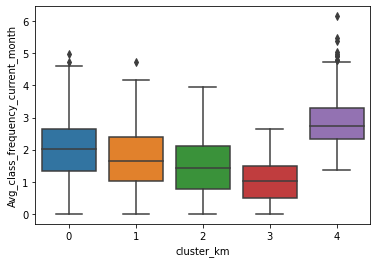

In [45]:
for column in ['Age',
 'Avg_additional_charges_total',
 'Month_to_end_contract',
 'Lifetime',
 'Avg_class_frequency_total',
 'Avg_class_frequency_current_month']:
    sns.boxplot(x ='cluster_km',y = column, data = df)
    plt.show()